# Import the required Libraries

In [1]:
!pip install umap-learn

In [2]:
import sys
import time
import spotipy
import yaml
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from pprint import pprint
import json
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap
from sklearn import datasets, metrics
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set()

In [3]:
sp_df=pd.read_csv('Spotify_rollingstone500.csv')


# Data cleaning

In [4]:
for column in sp_df:
    no_value=sp_df[column].eq(0).sum()
    if no_value>0:
        print(f'{no_value}   number of value 0 in column {column}')   

1   number of value 0 in column Unnamed: 0
163   number of value 0 in column instrumentalness


# Feature selection

In [5]:
# Drop unname and instrumentalness columns
sp_df.drop(sp_df.columns[0], axis=1,inplace=True)
sp_df.drop(columns=['instrumentalness'],inplace=True)
sp_df.shape

(524, 12)

In [6]:
def hist_df(df):
    for column in sp_df:
        if df[column].dtype == np.float64:
           plt.figure(column,figsize=(20,4))
           plt.title(column)
            #print(sp_df[column].dtype)
           sns.histplot(data=df, x=column,bins=50)
            
    #elif pd.api.types.is_string_dtype(sp_df[column]):
        #print(sp_df[column].dtype)
        #plt.figure(column,figsize=(20,4))
        #plt.title(column)
        #fig=sns.countplot(x=column,data=sp_df)

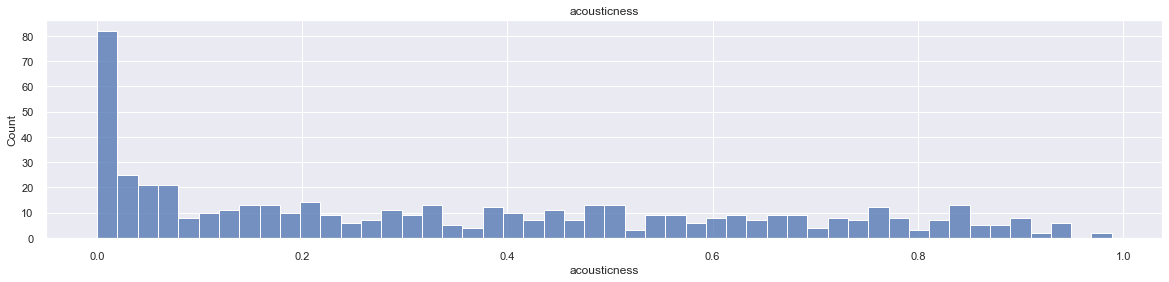

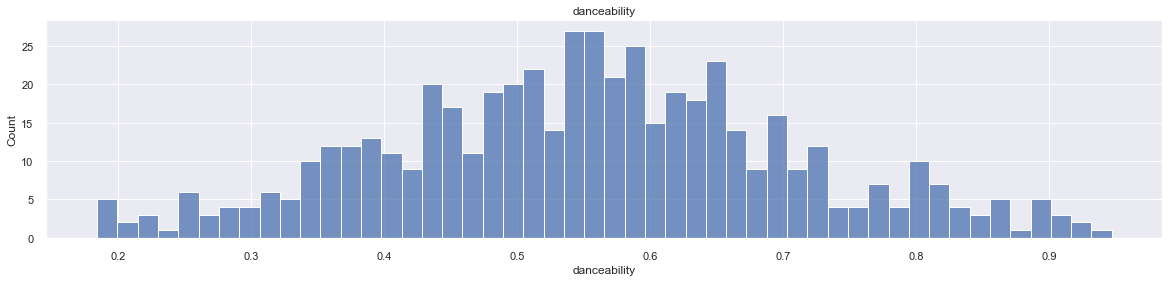

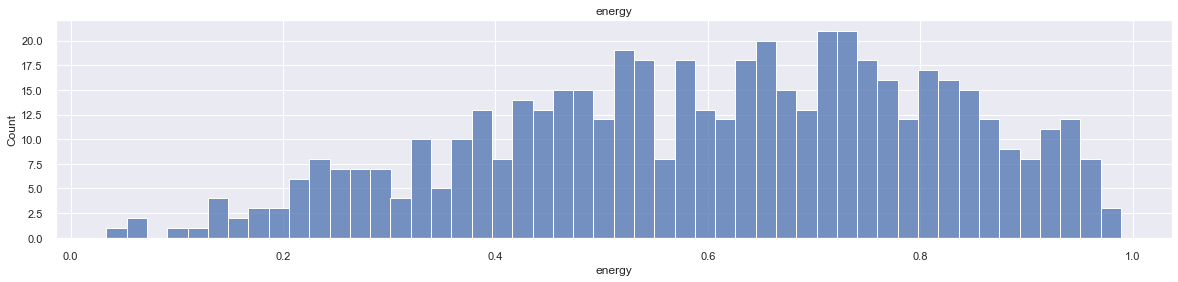

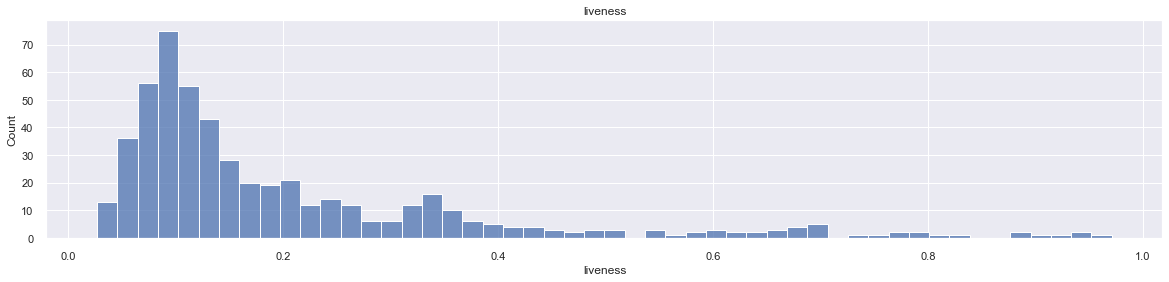

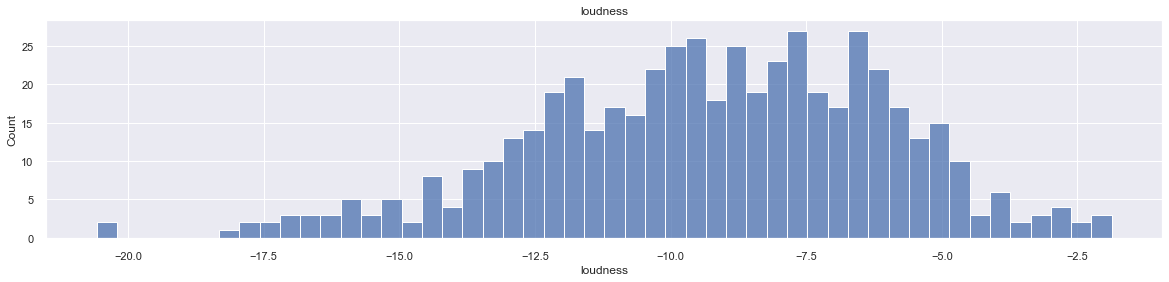

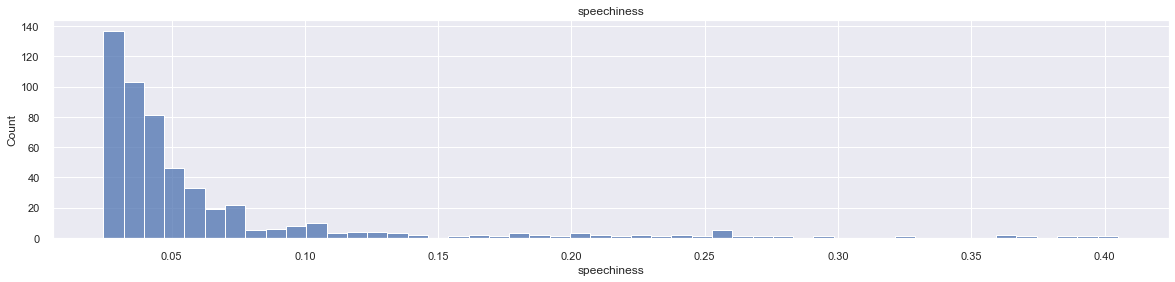

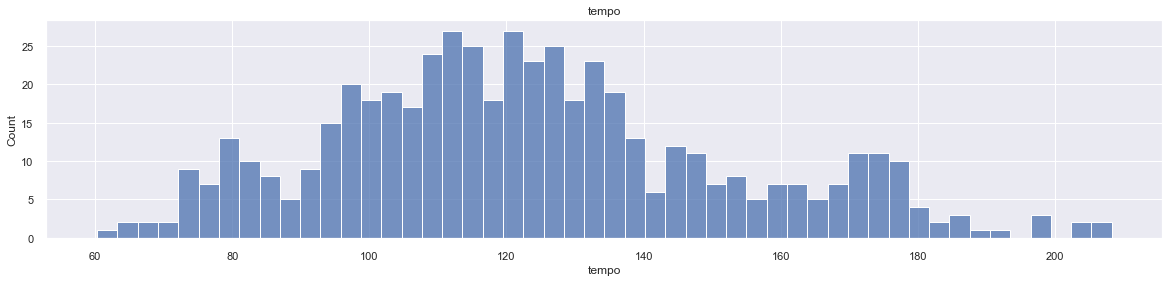

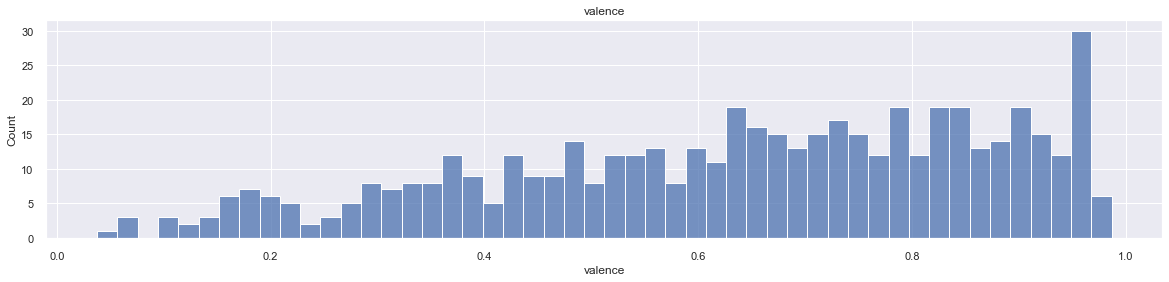

In [7]:
hist_df(sp_df)

# Principal Component Analysis - PCA


In [8]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = sp_df[non_features]
df_X = sp_df.drop(columns=non_features)
df_X.head()

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence
0,0.7570,0.479,0.704,0.2660,-6.858,0.0334,95.574,0.514
1,0.0348,0.725,0.853,0.1960,-7.842,0.0353,136.282,0.904
2,0.9070,0.547,0.257,0.0935,-12.358,0.0252,75.752,0.169
3,0.4030,0.280,0.720,0.3940,-9.668,0.1110,202.523,0.805
4,0.1500,0.819,0.537,0.0871,-5.223,0.0414,115.086,0.963


In [9]:
scaler = StandardScaler()
sp_df_std = scaler.fit_transform(df_X)

# DBSCAN Clustring

In [10]:
# Color pallete for clusters
flatui = ["#F80B00", "#65B6A8", "#2E3E3F",  "#E98935", "#B6BB92","#FDB606","#B8BC22"]

In [11]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(sp_df_std)


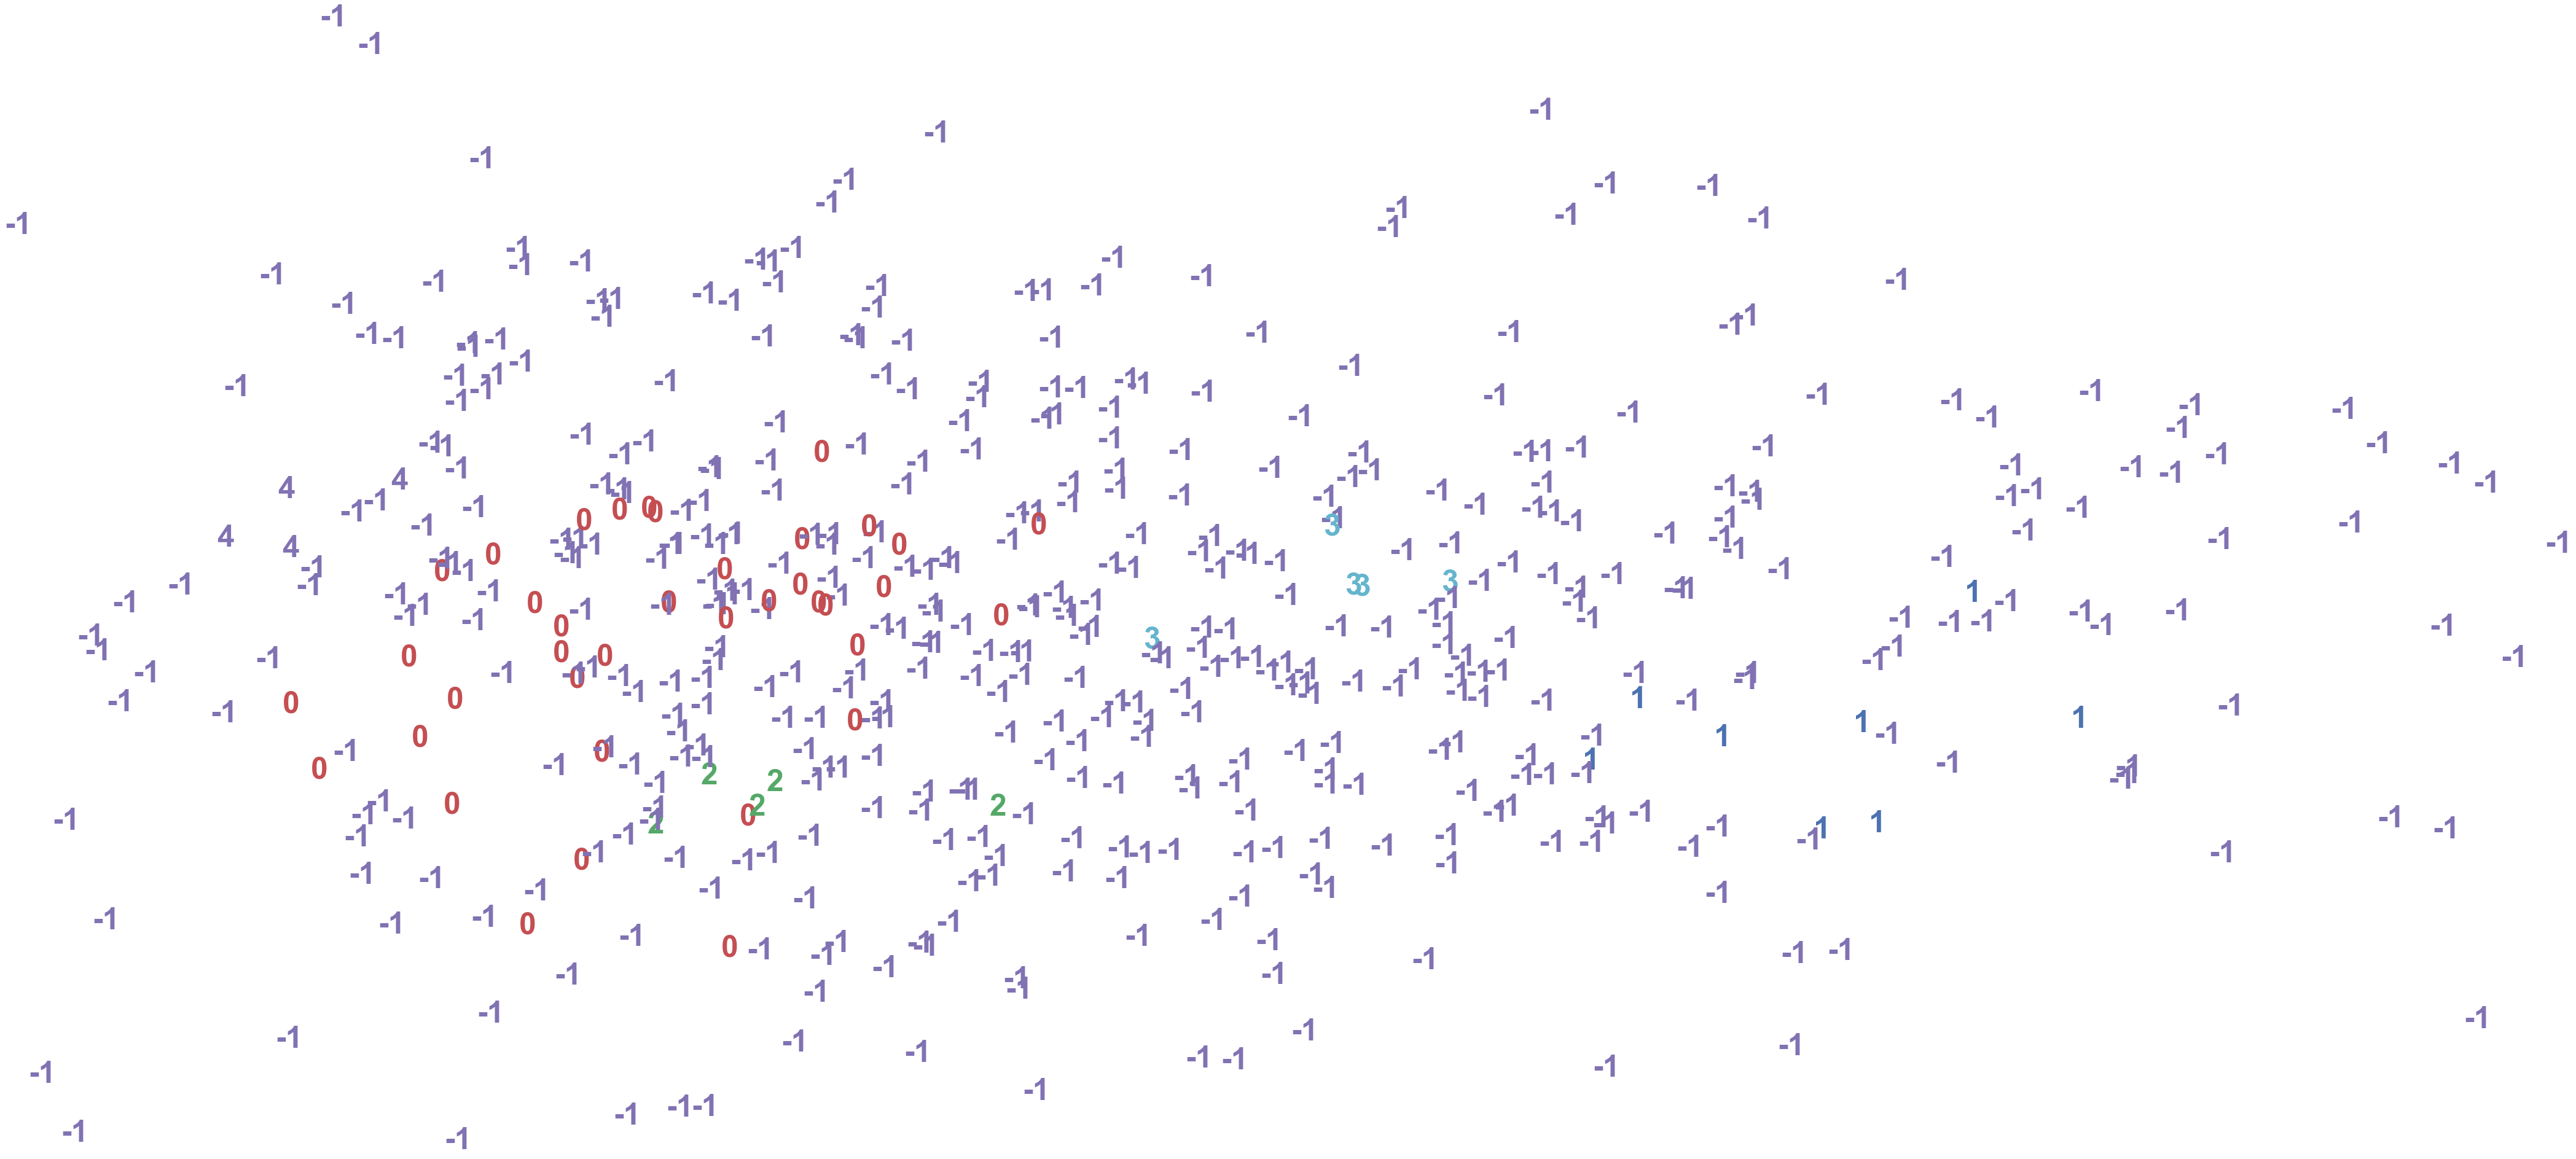

In [12]:
pca = PCA(n_components=2).fit_transform(sp_df_std)

plt.figure(figsize=(10,5))
colors = 'rbgcm'
for i in range(pca.shape[0]):
    
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color= colors[int(clusters[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# GMM Clustring

In [13]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(sp_df_std)

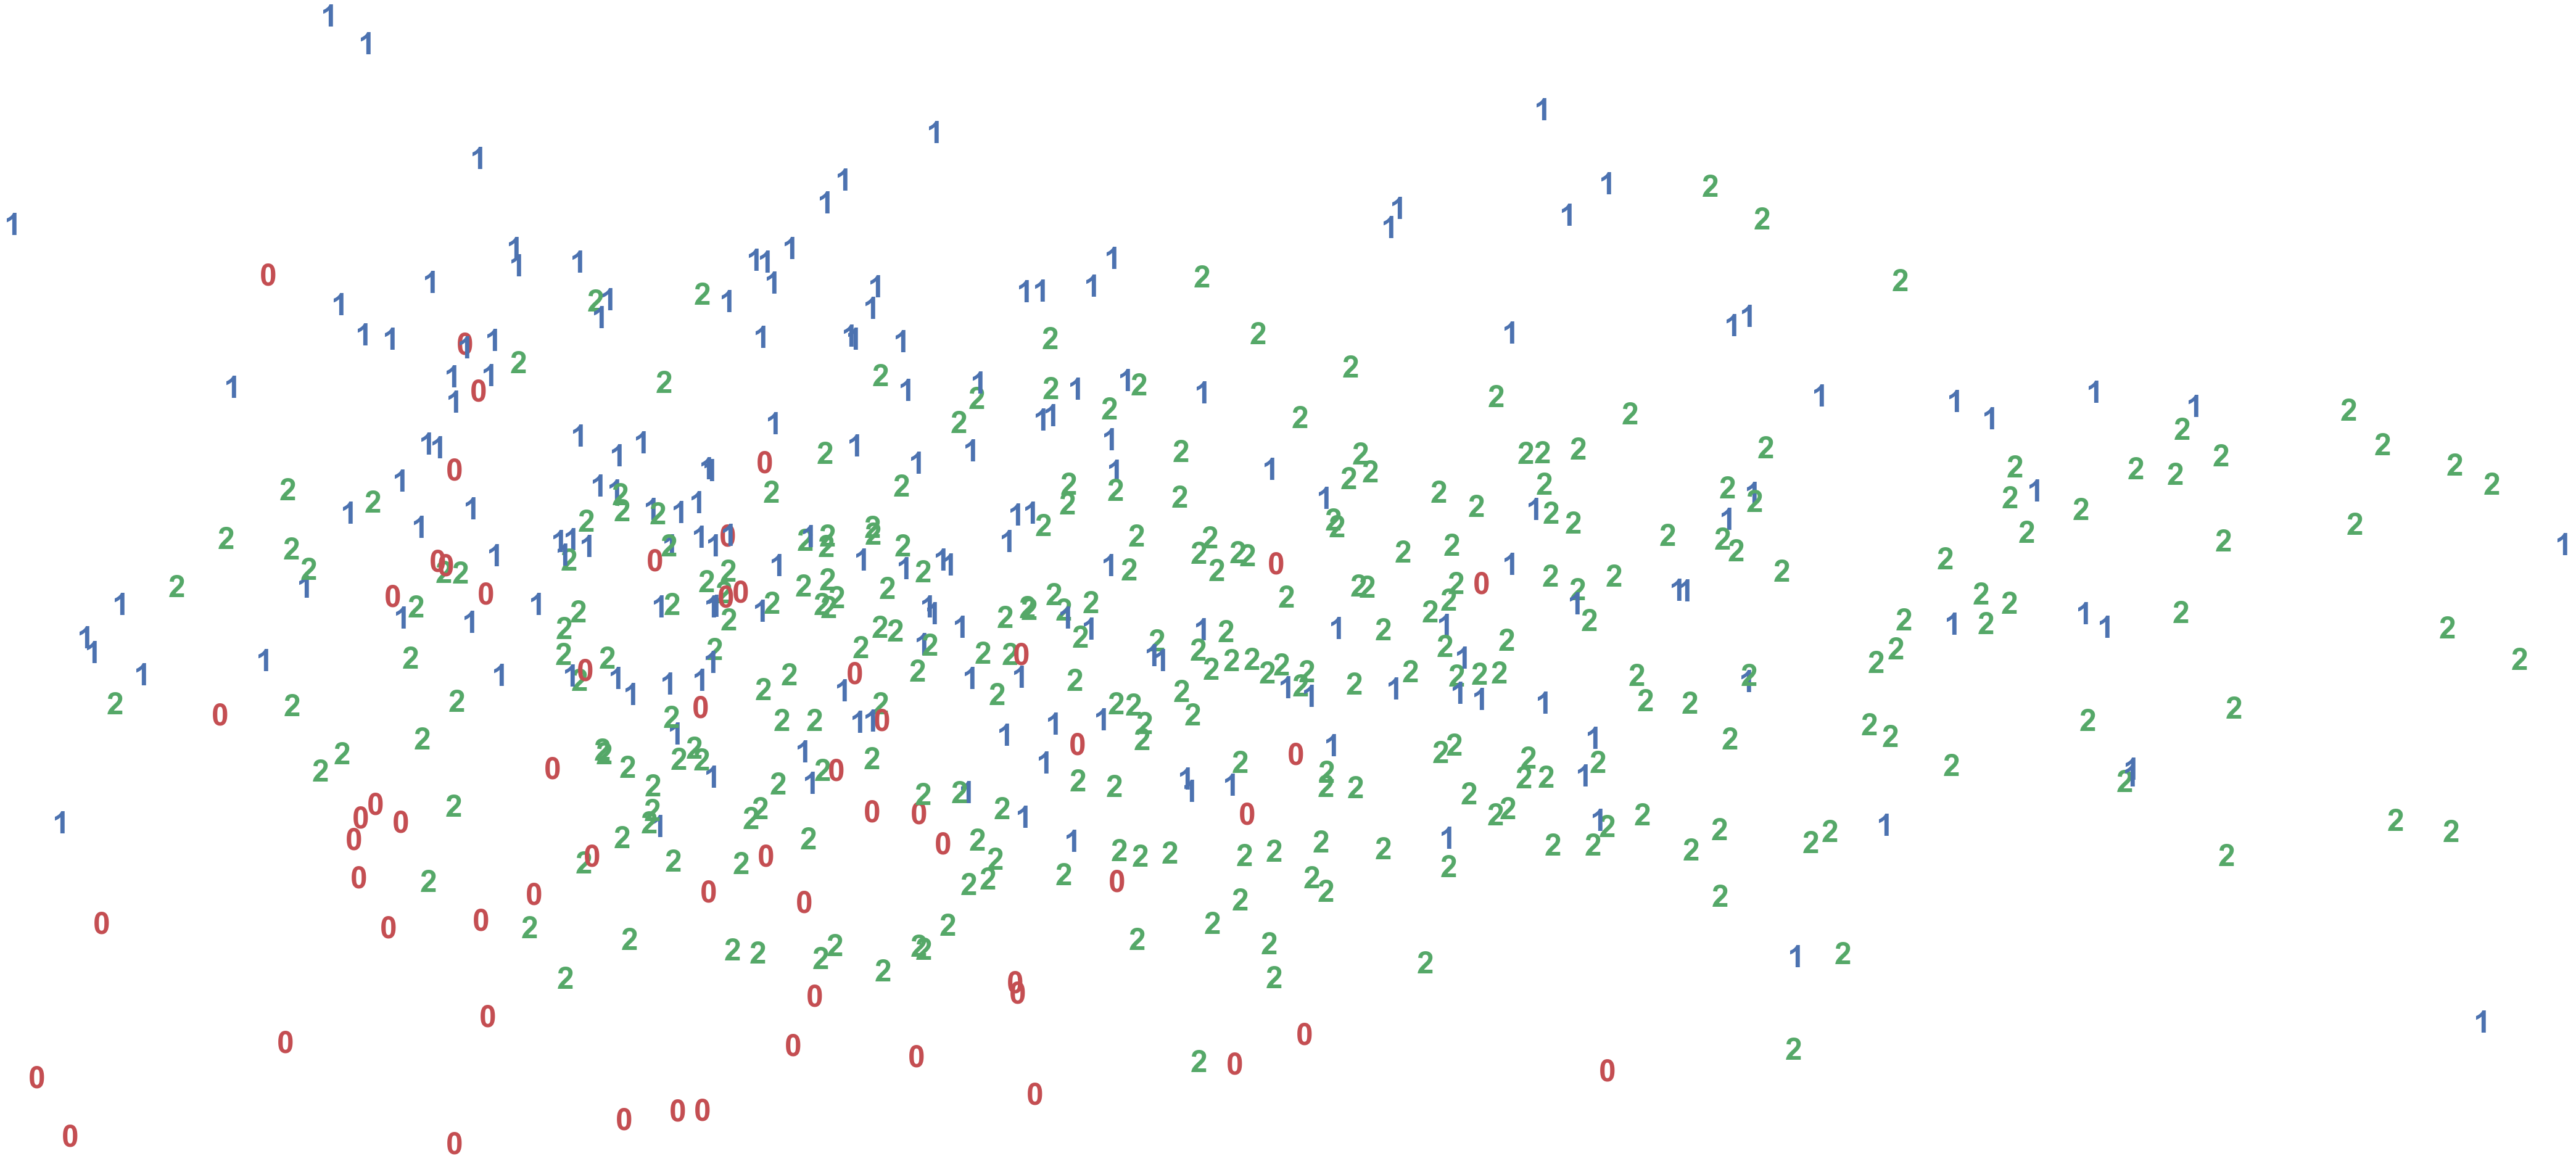

In [14]:
pca = PCA(n_components=2).fit_transform(sp_df_std)

plt.figure(figsize=(10,5))

for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colors[int(clusters[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# PCA Clustring

In [15]:
pca = PCA()
pca.fit(sp_df_std);

In [16]:
d_var = pca.explained_variance_ratio_
d_var

array([0.28946799, 0.1776301 , 0.13388005, 0.11810373, 0.11439617,
       0.09242478, 0.04949364, 0.02460354])

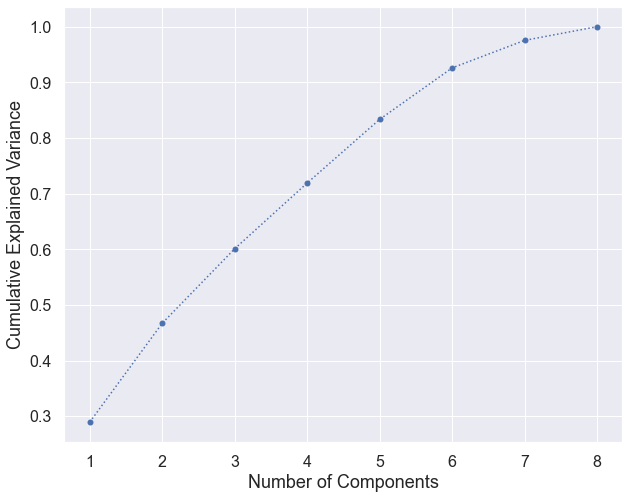

In [17]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(df_X.columns)+1), d_var.cumsum(), marker='o', linestyle=':')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig = plt.savefig("./visualizations/cumulative_variance_plot.png")
plt.show()

In [18]:
for i, exp_var in enumerate(d_var.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(sp_df_std)
scores_pca = pca.transform(sp_df_std)

Number of components: 5


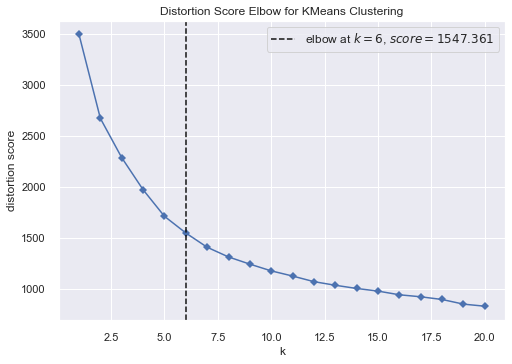

Optimal number of clusters: 6


In [19]:
model_k=KMeans()#(init='k-means++', random_state=42)
visualizer = KElbowVisualizer(model_k, k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [20]:
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    print(kmeans_pca.inertia_)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)


3493.939936866996
2671.0401090799514
2285.866796354926
1971.5981945627852
1711.639537920473
1547.523536994918
1406.9880371681973
1309.6113358298555
1242.5694107050838
1182.427843926308
1127.5751027416475
1069.8550715438241
1033.4380554784927
1000.1483643157569
966.2208070044086
933.9893718758452
901.7263729996137
872.9103283819062
855.378710211775
825.0151445938583
Optimal number of clusters 7


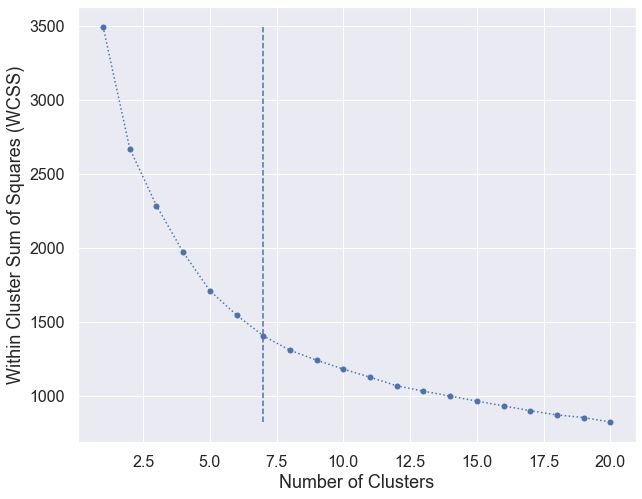

In [21]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle=':')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./visualizations/num_clusters.png")
plt.show()

# Kmeans Number of clusters silhouette score comparesion

In [22]:
s_score = [] 
for i in range(2,10):
    kmeans_pca_score = KMeans(n_clusters=int(i), init='k-means++', random_state=42).fit_predict(sp_df_std)
    ks_score=(metrics.silhouette_score(sp_df_std,kmeans_pca_score,metric='euclidean'))
    s_score.append(ks_score)
print(s_score)




[0.18377065067732953, 0.20320109301140743, 0.1540798756005262, 0.17160960416051677, 0.16897490721460676, 0.15767871295313624, 0.15372560560455262, 0.1564234377099835]


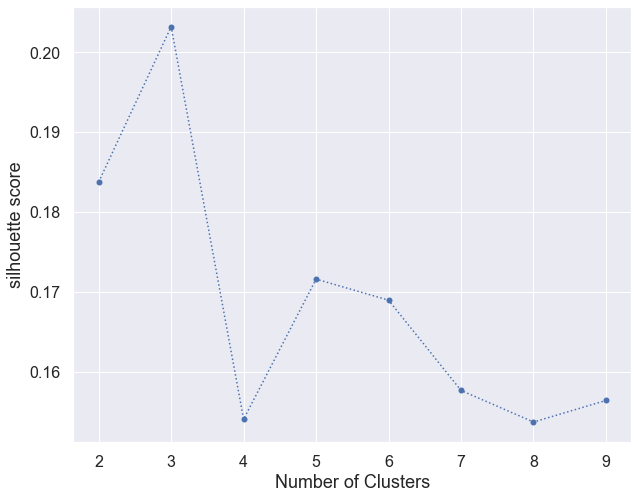

In [23]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(2, 10), s_score, marker='o', linestyle=':')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('silhouette score', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#fig.savefig("./visualizations/num_clusters.png")
plt.show()

# Making 5 clusters using Kmeans

In [24]:
n_clusters = 5
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);


In [25]:
df_clusters = pd.concat([df_X.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_clusters.columns.values[(-1*n_comps):] = ["k-mean Comp " + str(i+1) for i in range(n_comps)]
df_clusters['Cluster'] = kmeans_pca.labels_
df_clusters.head()

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,k-mean Comp 1,k-mean Comp 2,k-mean Comp 3,k-mean Comp 4,k-mean Comp 5,Cluster
0,0.7570,0.479,0.704,0.2660,-6.858,0.0334,95.574,0.514,0.368806,0.437115,0.978840,-0.674395,-0.176569,2
1,0.0348,0.725,0.853,0.1960,-7.842,0.0353,136.282,0.904,-1.888542,-0.673286,-0.716024,-0.654628,-0.377753,3
2,0.9070,0.547,0.257,0.0935,-12.358,0.0252,75.752,0.169,3.376616,-0.486554,1.122924,0.214619,-0.679969,1
3,0.4030,0.280,0.720,0.3940,-9.668,0.1110,202.523,0.805,-0.817926,2.251205,-1.372151,0.251579,2.278422,4
4,0.1500,0.819,0.537,0.0871,-5.223,0.0414,115.086,0.963,-1.285864,-1.869277,-0.572351,-0.690588,-0.664590,3


/Users/python/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


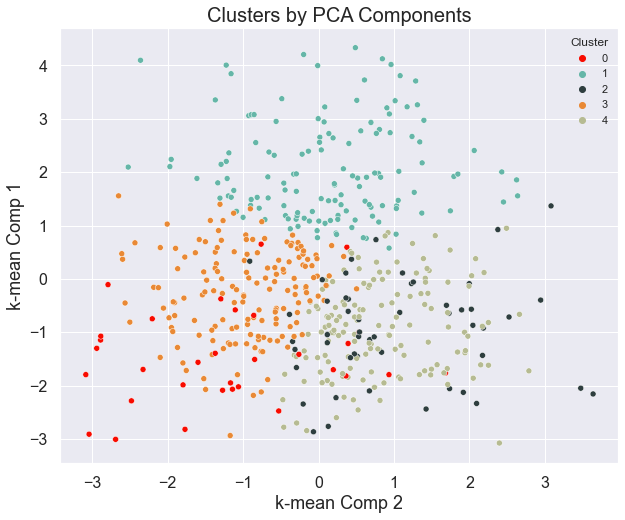

In [26]:
x = df_clusters['k-mean Comp 2']
y = df_clusters['k-mean Comp 1']

fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_clusters['Cluster'], palette = flatui[:n_clusters])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("k-mean Comp 2", fontsize=18)
plt.ylabel("k-mean Comp 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
#fig.savefig("./visualizations/clusters-2d.png")


In [27]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(sp_df_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 524 samples in 0.001s...
[t-SNE] Computed neighbors for 524 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 524 / 524
[t-SNE] Mean sigma: 1.039899
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.357452
[t-SNE] KL divergence after 300 iterations: 1.114072
t-SNE done! Time elapsed: 1.903459072113037 seconds


In [28]:
tsne_results

array([[ -5.090523 ,  -7.716815 ],
       [ -4.7004967,   2.6998506],
       [ 11.903609 ,   5.0908384],
       ...,
       [ -4.198696 , -14.152418 ],
       [ -1.2973077,  -6.1106696],
       [ -5.0400386,  13.418596 ]], dtype=float32)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

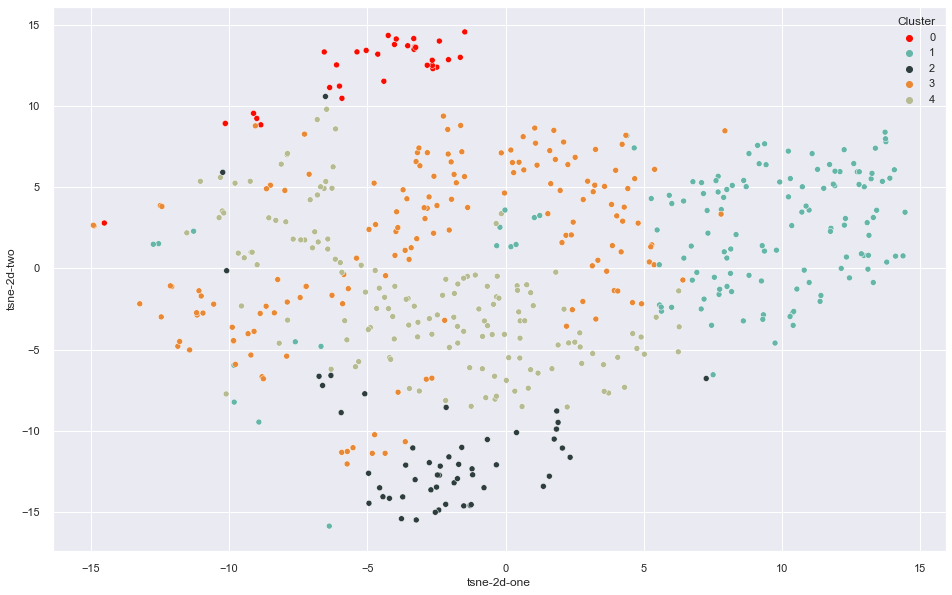

In [29]:


df_clusters['tsne-2d-one'] = tsne_results[:,0]
df_clusters['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Cluster",
    palette = flatui[:n_clusters],
    #palette=sns.color_palette("hls", 10),
    data=df_clusters,
    legend="full",
    
)

# UMAP

In [30]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(sp_df_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 8.64304780960083 seconds


In [31]:
umap_results
sp_df_umap=sp_df_std

In [32]:

df_clusters['umap-one'] = umap_results[:,0]
df_clusters['umap-two'] = umap_results[:,1]



<AxesSubplot:xlabel='umap-one', ylabel='umap-two'>

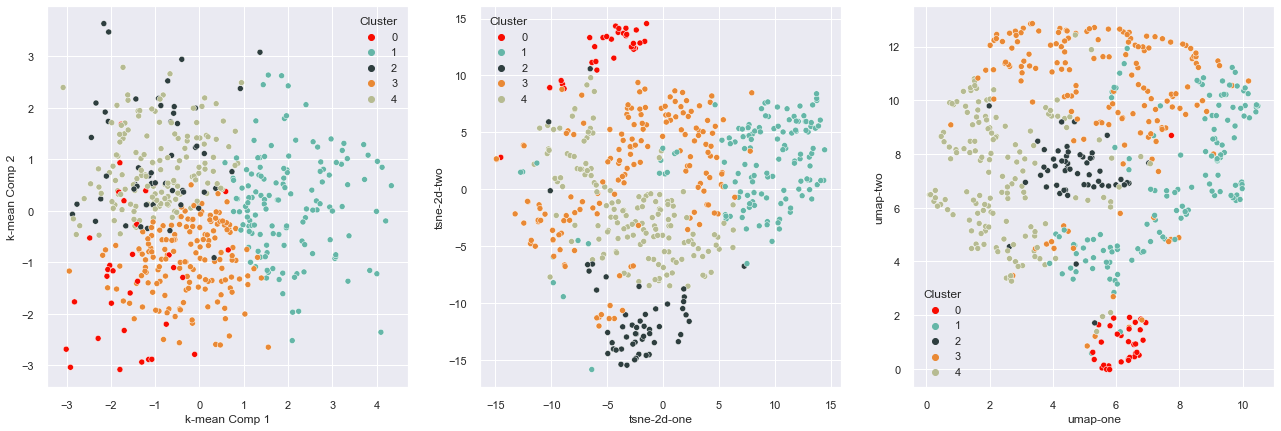

In [33]:
plt.figure(figsize=(22,7))
ax1 = plt.subplot(1,3, 1)
sns.scatterplot(
    x="k-mean Comp 1", y="k-mean Comp 2",
    hue="Cluster",
    palette=flatui[:n_clusters],
    data=df_clusters,
    legend="full",
    #alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Cluster",
    palette=flatui[:n_clusters],
    data=df_clusters,
    legend="full",
    #alpha=0.3,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x='umap-one', y='umap-two',
    hue="Cluster",
    palette=flatui[:n_clusters],
    data=df_clusters,
    legend="full",
    #alpha=0.3,
    ax=ax3
)


In [34]:
sp_df['Cluster'] = df_clusters['Cluster']
sp_df

,name,artist,track_URI,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence,playlist,Cluster
0,Like A Rolling Stone,Bob Dylan,spotify:track:4hR2PmKODnlFa5fe8iWzeo,0.75700,0.479,0.704,0.2660,-6.858,0.0334,95.574,0.514,500 Greatest songs of all time by Rolling ston...,2
1,(I Can't Get No) Satisfaction - Mono Version /...,The Rolling Stones,spotify:track:7fSGbZLhWlAiCC3HDPAULu,0.03480,0.725,0.853,0.1960,-7.842,0.0353,136.282,0.904,500 Greatest songs of all time by Rolling ston...,3
2,Imagine - Remastered 2010,John Lennon,spotify:track:7pKfPomDEeI4TPT6EOYjn9,0.90700,0.547,0.257,0.0935,-12.358,0.0252,75.752,0.169,500 Greatest songs of all time by Rolling ston...,1
3,What's Going On,Marvin Gaye,spotify:track:42PyxnviKRfOa8z39g8aZj,0.40300,0.280,0.720,0.3940,-9.668,0.1110,202.523,0.805,500 Greatest songs of all time by Rolling ston...,4
4,Respect,Aretha Franklin,spotify:track:3OYh9wHWqWD6bpmO3WQNlM,0.15000,0.819,0.537,0.0871,-5.223,0.0414,115.086,0.963,500 Greatest songs of all time by Rolling ston...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,Ignition - Remix,R. Kelly,spotify:track:5dNfHmqgr128gMY2tc5CeJ,0.06100,0.795,0.523,0.0914,-7.165,0.0423,133.024,0.855,500 Greatest songs of all time by Rolling ston...,3
520,The Rising,Bruce Springsteen,spotify:track:2czBvzOv3TvnyoW7Ozo7fP,0.06550,0.499,0.761,0.0895,-6.381,0.0324,110.186,0.326,500 Greatest songs of all time by Rolling ston...,4
521,Shop Around,The Miracles,spotify:track:6dHAIIaTDAY8Wmh6sQ1lX9,0.69200,0.549,0.703,0.6750,-4.923,0.0291,132.082,0.908,500 Greatest songs of all time by Rolling ston...,2
522,Rock Lobster (Single Version),The B-52's,spotify:track:0tACWEElJ2uC47STmG3wVq,0.00788,0.562,0.960,0.0501,-3.848,0.0605,90.308,0.555,500 Greatest songs of all time by Rolling ston...,4


In [35]:
def make_normalized_df(df):
    non_features = df.select_dtypes(include=['object'])
    features = df.select_dtypes(include=['float64'])
    norm = MinMaxScaler().fit_transform(features)
    scaled = pd.DataFrame(norm, index=df.index, columns = features.columns)
    return pd.concat([non_features, scaled], axis=1)

cluster_labels = sp_df['Cluster']
orig = sp_df.drop(columns=['playlist', 'Cluster'])
values_df = make_normalized_df(orig)
values_df.insert(3, 'cluster', cluster_labels)
values_df.head()

,name,artist,track_URI,cluster,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence
0,Like A Rolling Stone,Bob Dylan,spotify:track:4hR2PmKODnlFa5fe8iWzeo,2,0.765416,0.386632,0.701633,0.252941,0.733180,0.023647,0.238367,0.501738
1,(I Can't Get No) Satisfaction - Mono Version /...,The Rolling Stones,spotify:track:7fSGbZLhWlAiCC3HDPAULu,3,0.035171,0.709043,0.857621,0.178764,0.680554,0.028639,0.513454,0.912567
2,Imagine - Remastered 2010,John Lennon,spotify:track:7pKfPomDEeI4TPT6EOYjn9,1,0.917087,0.475754,0.233668,0.070149,0.439031,0.002102,0.104418,0.138312
3,What's Going On,Marvin Gaye,spotify:track:42PyxnviKRfOa8z39g8aZj,4,0.407473,0.125819,0.718384,0.388577,0.582897,0.227535,0.961083,0.808280
4,Respect,Aretha Franklin,spotify:track:3OYh9wHWqWD6bpmO3WQNlM,3,0.151654,0.832241,0.526801,0.063368,0.820623,0.044666,0.370221,0.974718


In [36]:
fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'polar'}]*4]*2,horizontal_spacing = 0.1)

angles = list(values_df.columns[4:])
angles.append(angles[0])
abbrev = ["Act", "Dnc", "Eng", "Li", "Lo", "Sp", "Te", "Va"]

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=abbrev,
        fill='toself',
        name="Playlist " + str(i)),
        i // 4 + 1,
        i % 4 + 1)
    
fig.update_layout(
        polar=layoutdict,
        polar2=layoutdict,
        polar3=layoutdict,
        polar4=layoutdict,
        polar5=layoutdict,
        polar6=layoutdict,
        polar7=layoutdict,
        #polar8=layoutdict,
        showlegend=True
        )
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.001,
    xanchor="right",
    x=1
))
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')

In [37]:
fig = go.Figure()

angles = list(values_df.columns[4:])
angles.append(angles[0])

layoutdict = dict(
            radialaxis=dict(
            visible=True,
            range=[0, 1]
            ))

for i in range(n_clusters):
    subset = values_df[values_df['cluster'] == i]
    data = [np.mean(subset[col]) for col in subset.columns[4:]]
    data.append(data[0])
    fig.add_trace(go.Scatterpolar(
        r=data,
        theta=angles,
        fill='toself',
        name="Playlist " + str(i)))
    
fig.update_layout(
        polar=layoutdict,
        showlegend=True
        )
fig.show()
#     fig.write_image('./visualizations/cluster' + str(i) + '.png')


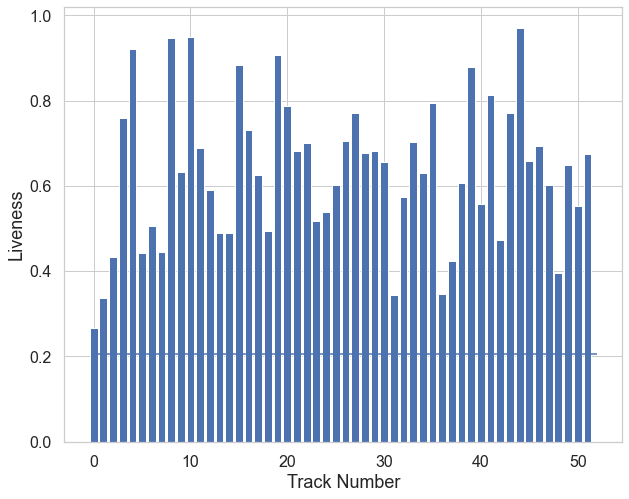

In [43]:

def cluster_plot(df, param, cluster):
    plt.figure(figsize=(10,8))
    test_cluster = df.loc[df['Cluster'] == cluster]
    y = test_cluster[param]
    x = [i for i in range(len(y))]
    plt.bar(x, y)
    plt.xlabel('Track Number', fontsize=18)
    plt.ylabel(param.title(), fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.hlines(np.mean(df[param]), 0, len(y))
    plt.show()
    
cluster_plot(sp_df, "liveness", 2)

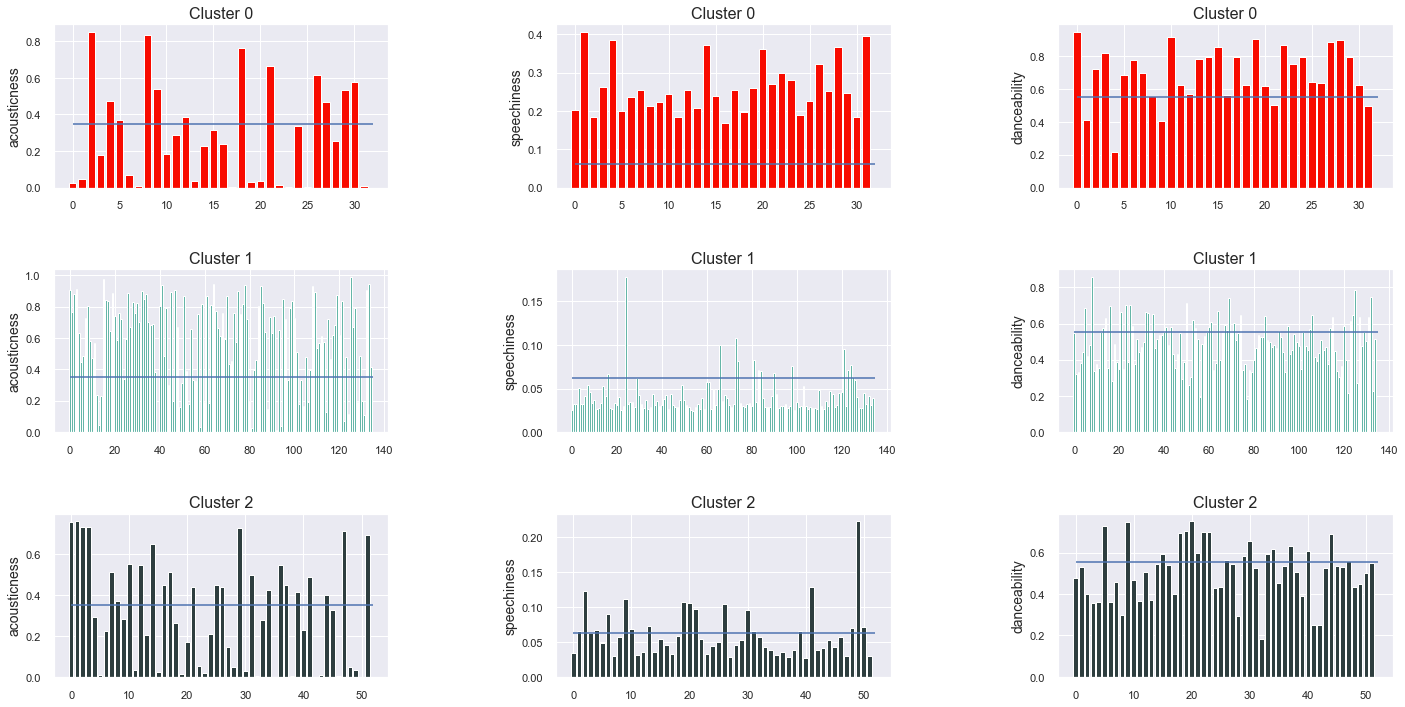

In [39]:
clusters = [0, 1, 2]
features = ["acousticness", "speechiness", "danceability"]
colors = ['tab:green', 'tab:olive', 'tab:cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim, dim, figsize=(24, 12))
i = 0
f = 0
test_cluster = sp_df.loc[sp_df['Cluster'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = sp_df.loc[sp_df['Cluster'] == clusters[i // dim]]
    
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y, color=flatui[i//dim])
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(sp_df[col]), 0, len(y))
    plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1
    
#fig.savefig("./visualizations/cluster_feature_bar_charts_dim_3.png")

In [40]:
sp_df.columns

Index(['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist',
       'Cluster'],
      dtype='object')

In [41]:
names=['name', 'artist', 'track_URI']

for c in sp_df.Cluster.unique():
    cl = sp_df.loc[sp_df['Cluster'] == c]
    cl = pd.DataFrame(cl, columns=names)
    exec(f'cluster{c} = cl')

#cluster2 = sp_df.loc[sp_df['Cluster'] == 2]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster3 = sp_df.loc[sp_df['Cluster'] == 3]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster4 = sp_df.loc[sp_df['Cluster'] == 4]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster5 = sp_df.loc[sp_df['Cluster'] == 5]
#cluster1 = pd.DataFrame(cluster1, columns=names)

#cluster6 = sp_df.loc[sp_df['Cluster'] == 6]
#cluster1 = pd.DataFrame(cluster1, columns=names)


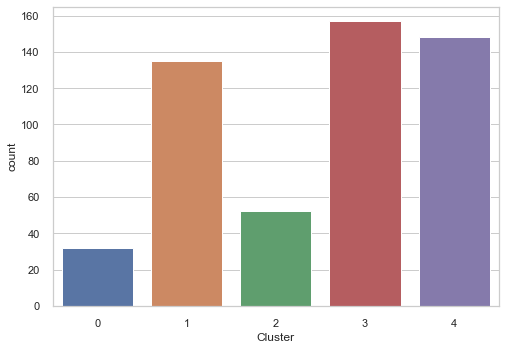

In [42]:

sns.set_theme(style="whitegrid")
ax = sns.countplot(x="Cluster", data=sp_df)
